In [65]:
import yfinance as yf
import pandas as pd

In [66]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")

In [68]:
sp500.index = pd.to_datetime(sp500.index)

<Axes: xlabel='Date'>

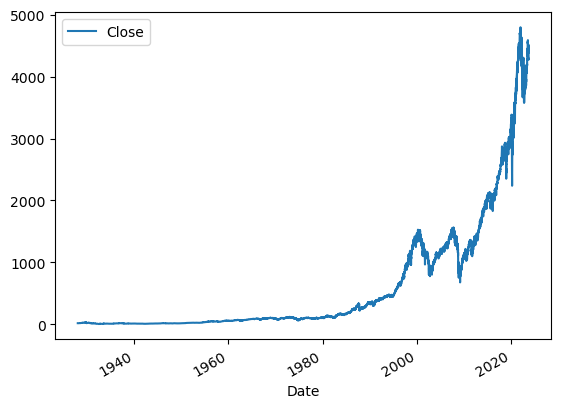

In [70]:
sp500.plot.line(y="Close", use_index=True)

In [71]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [72]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [73]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500 = sp500.loc["1990-01-01":].copy()

In [74]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=150, min_samples_split=80, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=80, n_estimators=150, random_state=1)

In [75]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds, zero_division=1)

0.5373134328358209

<Axes: xlabel='Date'>

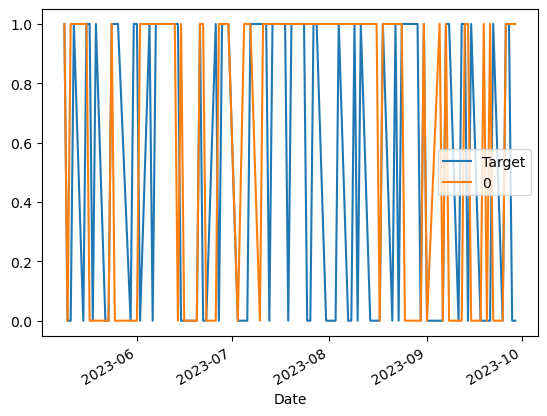

In [76]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [77]:
def predict(train, test, model, predictors):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [78]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, model, predictors)
        all_predictions.append(predictions)
        
    return pd.concat(all_predictions)

In [79]:
predictions = backtest(sp500, model, predictors)

In [80]:
predictions["Predictions"].value_counts()

0    3380
1    2622
Name: Predictions, dtype: int64

In [81]:
precision_score(predictions["Target"], predictions["Predictions"])

0.522883295194508

In [82]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.533489
0    0.466511
Name: Target, dtype: float64

In [83]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [84]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [85]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [86]:
def predict(train, test, model, predictors):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [87]:
predictions = backtest(sp500, model, new_predictors)

In [88]:
predictions["Predictions"].value_counts()

0.0    4181
1.0     821
Name: Predictions, dtype: int64

In [89]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5688185140073082

In [90]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.543183
0    0.456817
Name: Target, dtype: float64